## Loading Original Data

In [1]:
from scipy import ndimage
from skimage.transform import rescale
import matplotlib.pyplot as plt # to visualize only 
import pandas as pd
import gc
import numpy as np 
import cv2

In [ ]:
original_x = pd.read_csv("./data/train_x.csv", delimiter=",", header = None) # load from text 

# have to reformat
original_x = original_x.values
original_x = original_x.astype(np.float32)

In [2]:
y = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)
# have to reformat
y = (y.values).ravel()

In [3]:
#visualizing 5 images indexes in array images by start and shows corresponding labels
def plotter(images, labels, start):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[start:start+5], labels[start:start+5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (64,64)), cmap= 'gray')
        plt.title('Training: %i\n' % label, fontsize = 20)

In [ ]:
# sanity check: is this the image data we think it is?
plotter(original_x, y, 0)

## Processing the data

### Making background all black

In [ ]:
# since we know the numbers are white, can set a high threshold
# and set anything below that threshold to be black (0)
def binarize_element(x, threshold = 250):
    # make this less than to get black digits and white background
    if x > threshold:
        x = 255
        return x
    else:
        x = 0
        return x

In [ ]:
# making the data black and white
new_x = np.zeros((original_x.shape[0], original_x.shape[1]))
for i in range(len(new_x)):
    new_x[i] = list(map(binarize_element, original_x[i]))

In [ ]:
# sanity check: did the images become black and white?
plotter(new_x, y, 0)

In [ ]:
# writing the black and white images to a file
df = pd.DataFrame(new_x)
df.to_csv("./data/bw_x.csv", header = False, index = False)

In [ ]:
# more preprocessing on the black and white images
x = pd.read_csv("./data/bw_x.csv", delimiter=",", header = None)
x = x.values

In [ ]:
# sanity check: data is unchanged from last step
plotter(x, y, 0)

### Getting the largest digit

In [ ]:
new_x = np.zeros((x.shape[0], x.shape[1]))

In [ ]:
# first argument is original data, second argument is where new images will be stored
def find_largest_digit(image):
    im = np.reshape(image, (64,64))

    # connected components
    labeled_image, num_features = ndimage.label(im)

    # various dimensions of connected components
    objs = ndimage.find_objects(labeled_image)

    # height and width of connected components
    measurements = []
    for ob in objs:
        measurements.append((int(ob[0].stop - ob[0].start), int(ob[1].stop - ob[1].start)))

    # find the connected componnent (ie digit) with maximum height or width in the image
    index = max(enumerate(measurements), key=lambda x: max(x[1]))[0]
    # and get its bounding box
    min_y, max_y = objs[index][0].start, objs[index][0].stop
    min_x, max_x = objs[index][1].start, objs[index][1].stop

    # add a little padding to bounding box
    padding = 2
    if(min_y > 1):
        min_y -= padding
    if(max_y < 63):
        max_y += padding
    if(min_x > 1):
        min_x -= padding
    if(max_x < 63):
        max_x += padding

    #only get the largest digit
    image_cropped = im[min_y:max_y,min_x:max_x]
    image_cropped = image_cropped.astype(np.uint32)
    
    #resize the image
    h,w = image_cropped.shape
    heightIsBigger = True if h > w else False
    biggerDim, smallerDim = max(h, w), min(h, w)
    scale = 64 / biggerDim
    img = rescale(image_cropped, scale, mode="reflect")
    if heightIsBigger:
        diff = 64 - img.shape[1]
        padSize1, padSize2 = int(diff / 2), int(diff / 2) if diff % 2 == 0 else int(diff / 2) + 1
    else:
        diff = 64 - img.shape[0]
        padSize1, padSize2 = int(diff / 2), int(diff / 2) if diff % 2 == 0 else int(diff / 2) + 1
    paddingDims = ((0,0),(padSize1,padSize2)) if h > w else ((padSize1,padSize2),(0,0))
    
    img = np.pad(img, paddingDims, 'constant', constant_values=0)

    return img.reshape(4096)
    

In [ ]:
# oh yeah preprocess the whole thing
for i in range(len(x)):
    new_x[i] = find_largest_digit(x[i])

In [ ]:
# sanity check: did the preprocessing come out nice?
plotter(new_x, y, 0)

In [ ]:
# print the black and white rescaled data for use in the other ML algos
df = pd.DataFrame(new_x)
df.to_csv("./data/bw_rescaled_x.csv", header = False, index = False)

### Inverting black & white

In [4]:
new_x = pd.read_csv("./data/bw_rescaled_x.csv", delimiter=",", header = None)
new_x = new_x.values

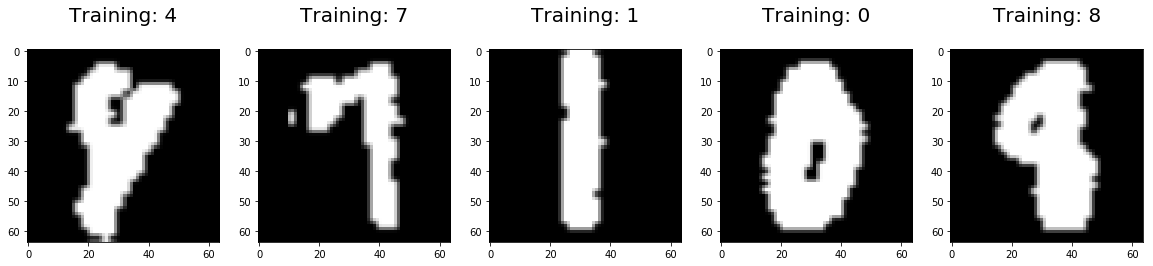

In [5]:
plotter(new_x, y, 0)

In [11]:
(new_x[0, (64*9):(64*10)])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.62314733e-09, 2.45634747e-08, 4.02937788e-08,
       4.91672836e-08, 5.80407884e-08, 5.93718141e-08, 5.93718141e-08,
       5.93718141e-08, 5.93718141e-08, 5.93718141e-08, 5.93718141e-08,
       5.93718141e-08, 5.93718141e-08, 5.93718141e-08, 5.93718141e-08,
       5.93718141e-08, 5.03369729e-08, 2.45231406e-08, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [21]:
#better to make the digits black and the background white
def invert_element(x):
    if (x*1e8) < 5.937:
        x = 255
        return x
    else:
        x = 0
        return x

In [25]:
bw_x = np.zeros((new_x.shape[0],new_x.shape[1]))
for i in range(len(bw_x)):
    bw_x[i] = list(map(invert_element, new_x[i]))

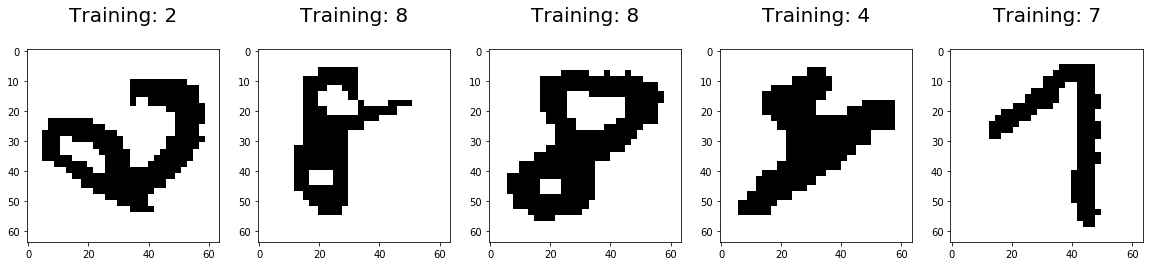

In [28]:
plotter(bw_x, y, 4540)

### Blurring digit

In [29]:
def blur_image(images, new_images):
    for i in range(images.shape[0]):
        im = np.reshape(images[i], (64,64))

        #blurring the image
        kernel = np.ones((5,5),np.float32)/25
        img = cv2.filter2D(im,-1,kernel)
        new_images[i] = np.reshape(img, 4096)

In [30]:
processed_x = np.zeros((bw_x.shape[0], bw_x.shape[1]))

blur_image(bw_x, processed_x)

In [35]:
# plotter(processed_x, y, 10)

## Preprocessing Pipeline

Looking at the progression of preprocessing 

In [ ]:
plotter(original_x, y, 1100)

In [ ]:
plotter(x, y, 1100)

In [ ]:
plotter(new_x, y, 1100)

In [ ]:
plotter(bw_x, y, 1100)

In [ ]:
plotter(processed_x, y, 0)

In [36]:
#saving fully preprocessed training file to a csv so that we never have to do all of that again

df = pd.DataFrame(processed_x)
df.to_csv("./data/processed_x.csv", header = False, index = False)

In [ ]:
'''del(x)
del(new_x)
del(bw_x)
del(processed_x)
del(original_x)
gc.collect()'''

# View final preprocessed data

In [38]:
x = pd.read_csv("./data/processed_x.csv", delimiter=",", header = None) # load from processed images

In [39]:
x = x.values

x = x.astype(np.float32)
x /= 255

In [ ]:
y = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)
y = (y.values).ravel()

In [41]:
# plotter(x, y, 0)

### Augmentation - might not include

In [ ]:
rotations = [-20, 20]

new_y = np.zeros(3*y.shape[0])
new_x = np.zeros((3*x.shape[0], x.shape[1]))

y_pos = 0
x_pos = 0

for i in range(x.shape[0]):
    im = np.reshape(x[i], (64,64))
    
    #blurring the image
    kernel = np.ones((5,5),np.float32)/25
    img = cv2.filter2D(im,-1,kernel)
    
    new_y[y_pos:y_pos+3] = y[i]
    y_pos += 3
    new_x[x_pos] = np.reshape(img, 4096)
    x_pos += 1
    
    for degree in rotations:
        rotated = ndimage.interpolation.rotate(im, degree, reshape=False, order=1, mode='nearest')
        kernel = np.ones((5,5),np.float32)/25
        rot = cv2.filter2D(rotated,-1,kernel)
        rot = np.reshape(rot, 4096)
        new_x[x_pos] = rot
        x_pos += 1

In [ ]:
plotter(new_x, new_y, 4)

In [ ]:
del(x)
del(y)
gc.collect()

In [ ]:
x_df = pd.DataFrame(new_x)
y_df = pd.DataFrame(new_y)

In [ ]:
x_df.to_csv("./data/augmented_x.csv", header = False, index = False)

In [ ]:
y_df.to_csv("./data/augmented_y.csv", header = False, index = False)

# Preprocessing Test Data

In [ ]:
test_x = pd.read_csv("./data/test_x.csv", delimiter=",", header = None)

In [ ]:
# reformat data 
test_x = test_x.values
test_x = test_x.astype(np.float32)

In [ ]:
#visualizing a random 5 images
indices = list(range(test_x.shape[0]))
plotter(test_x, indices, 0)

In [ ]:
#making the data black and white
new_test_x = np.zeros((test_x.shape[0], test_x.shape[1]))
for i in range(len(new_test_x)):
    new_test_x[i] = list(map(binarize_element, test_x[i]))

In [ ]:
plotter(new_test_x, indices, 0)

In [ ]:
#finding the largest digit in the test image
digit_test_x = np.zeros((new_test_x.shape[0], new_test_x.shape[1]))
for i in range(len(digit_test_x)):
    digit_test_x[i] = find_largest_digit(new_test_x[i])

In [ ]:
plotter(digit_test_x, indices, 0)

In [ ]:
df = pd.DataFrame(digit_test_x)
df.to_csv("./data/bw_rescaled_test_x.csv", header = False, index = False)

In [ ]:
#inverting black and white in test image
bw_test_x = np.zeros((digit_test_x.shape[0],digit_test_x.shape[1]))
for i in range(len(bw_test_x)):
    bw_test_x[i] = list(map(invert_element, digit_test_x[i]))

In [ ]:
plotter(bw_test_x, indices, 0)

In [ ]:
#blurring the test image
processed_test_x = np.zeros((bw_test_x.shape[0], bw_test_x.shape[1]))
blur_image(bw_test_x, processed_test_x)

In [ ]:
plotter(processed_test_x, indices, 0)

In [ ]:
df = pd.DataFrame(processed_test_x)

df.to_csv("./data/processed_test_x.csv", header = False, index = False)